# Reinforcement learning

## Evolutionary algorithms


In [1]:
import gymnasium as gym
import numpy as np
# for allowing abstract methodes (closest thing to interface)
from abc import ABC, abstractmethod

# Agent erft over van de klasse ABC
class Agent(ABC):

    num_parents = 1

    @abstractmethod
    def _init_weights(self):
        # initialisatie met random gewichten
        pass

    @abstractmethod
    def copy(self):
        # dit is een trucje om nieuwe agents te krijgen van 1
        pass

    @abstractmethod
    def get_action(self, observation=None):
        # wat is de actie op basis van mijn huidige state (predict)
        pass

    @abstractmethod
    def mutate(parents=None, mutation_rate=None):
        # heel domme fit, neem de gewichten over van de parent en muteer ze
        # als hij door de mutaties beter scoort dan de parent, zal hij blijven bestaan.
        # anders sterft hij uit
        pass

In [2]:
# Define the MountainCar environment
env = gym.make("MountainCar-v0")

# simulate single training run
def simulate_env(env, agent):
    observation = env.reset()[0]
    done = False

    # return of cumulatieve reward
    ret = 0

    while not done:
        # Forward pass through the neural network (manueel geschreven)
        action = agent.get_action(observation)

        # Take the selected action and observe the next state and reward
        observation, reward, terminated, truncated, _ = env.step(action)
        ret += reward
        done = truncated or terminated

    return ret

In [3]:
# train a reinforcment learning agent
def train_agent(env, agent, population_size = 50, mutation_rate=0.4, num_generations = 100, num_episodes=5):
    # population_size = aantal giraffen waarmee we werken
    # mutation_rate = hoe sterk verschillen de kinderen van hun ouders
    # num_generations = aantal epochs
    # num_episodes = aantal folds in k-cross validation

    # Initialize the population
    population = [agent.copy() for _ in range(population_size)]

    # number of generations in the algorithm
    for generation in range(num_generations):
        scores = []

        # Evaluate each individual in the population
        for current_pop in population:
            total_reward = 0

            # Run multiple episodes to evaluate an individual's performance
            for _ in range(num_episodes):
                total_reward += simulate_env(env, current_pop)

            # Calculate the average score for this individual
            scores.append(total_reward / num_episodes)

        # Select the top-performing individuals
        # met de standaardwaarden wil deze lijn zeggen: neem de 10 agents met de grootste score
        # argsort - sorteer de array maar geef de volgorde van de incides
        elite_indices = np.argsort(scores)[-int(0.2 * population_size):]

        # Create a new population by mutating and recombining the elite individuals
        new_population = [population[elite_indices[-1]]]  # keep best individual

        while len(new_population) < population_size:
            # dit stukje code is flexibel, het aantal parents kan dus gekozen worden
            # kies num_parents willekeurige ouders
            indices = np.random.choice(elite_indices, size=agent.num_parents)
            # neem de parents uit de population array
            parents = [population[index] for index in indices]
            # maak een nieuwe populatie
            new_population.extend(current_pop.mutate(parents, mutation_rate))

        # dood de vorige populatie en vervang het door de nieuwe
        population = new_population

        # Print the best score in this generation
        best_score = max(scores)
        if best_score > -140:
            mutation_rate = 0.1
        print(f"Generation {generation + 1}: Best Score = {best_score}")
    
    # return best individual
    return population[0]

In [4]:
class EvolutionaryAgent(Agent):
    num_parents = 1

    # aantal inputs = de grootte van de observation space
    # aantal outputs = het aantal mogelijke acties
    # hidden_layer_sizes = we werken met een NN -> het aantal neuronen per hidden laag
    def __init__(self, num_inputs=1, num_outputs=1, hidden_layer_sizes=[]) -> None:
        super().__init__()

        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.hidden_layers_sizes = hidden_layer_sizes
        
        self._init_weights()
        
    def _init_weights(self):
        #print(self.hidden_layers_sizes)
        if len(self.hidden_layers_sizes) == 0:
            self.weights = [np.random.randn(self.num_inputs, self.outputs)]
        else:
            self.weights = []

            for index, hidden_layer in enumerate(self.hidden_layers_sizes):
                if index == 0:
                    # eerst stap is van de inputs naar de eerste hidden layer
                    self.weights.append(np.random.randn(self.num_inputs, hidden_layer))
                else:
                    # weights om van de vorige hidden layer naar de huidige te gaan
                    self.weights.append(np.random.randn(self.hidden_layers_sizes[index-1], hidden_layer))

            # van de laatste hidden layer naar de outputs                
            self.weights.append(np.random.randn(hidden_layer, self.num_outputs))

        #for layer in self.weights:
        #    print(layer.shape)
                
    def copy(self):
        agent = EvolutionaryAgent(self.num_inputs, self.num_outputs, self.hidden_layers_sizes)
        agent._init_weights()

        return agent
        
    # predict de stap van het NN - forward pass
    def get_action(self, observation=None):

        action_prob = observation

        for index, hidden_layer in enumerate(self.weights):
            if index == len(self.weights)-1:
                # lineaire activatiefunctie in de output layer (vorm van regressie)
                action_prob = np.dot(action_prob, hidden_layer)
            else:
                # dit is wat er gebeurd bij de predict in een dense layer met tanh activatiefunctie
                action_prob = np.tanh(np.dot(action_prob, hidden_layer))

        # return de beste actie
        return np.argmax(action_prob)

    def mutate(self, parents=None, mutation_rate=None):
        # check om te zien of de parent van hetzelfde type is
        if not isinstance(parents, list) and not isinstance(parents[0], EvolutionaryAgent):
            return
        
        self.weights = [layer + mutation_rate * np.random.randn(*layer.shape) for layer in parents[0].weights]

        return [self]

In [5]:
# Define the MountainCar environment
env = gym.make("MountainCar-v0")

# Hyperparameters
population_size = 100
mutation_rate = 0.4
num_generations = 100
num_episodes = 5

# RL agent with internally a NN with 1 hidden layer of 8 neurons
input_size = env.observation_space.shape[0]
output_size = env.action_space.n
agent = EvolutionaryAgent(num_inputs=input_size, num_outputs=output_size, hidden_layer_sizes=[32])

best_evolutionary_agent = train_agent(env, agent, population_size=population_size, mutation_rate=mutation_rate, num_generations=num_generations, num_episodes=num_episodes)

Generation 1: Best Score = -200.0
Generation 2: Best Score = -200.0
Generation 3: Best Score = -200.0
Generation 4: Best Score = -200.0
Generation 5: Best Score = -200.0
Generation 6: Best Score = -200.0
Generation 7: Best Score = -200.0
Generation 8: Best Score = -200.0
Generation 9: Best Score = -200.0
Generation 10: Best Score = -200.0
Generation 11: Best Score = -200.0
Generation 12: Best Score = -200.0
Generation 13: Best Score = -200.0
Generation 14: Best Score = -200.0
Generation 15: Best Score = -200.0
Generation 16: Best Score = -200.0
Generation 17: Best Score = -200.0
Generation 18: Best Score = -200.0
Generation 19: Best Score = -200.0
Generation 20: Best Score = -200.0
Generation 21: Best Score = -200.0
Generation 22: Best Score = -200.0
Generation 23: Best Score = -200.0
Generation 24: Best Score = -200.0
Generation 25: Best Score = -200.0
Generation 26: Best Score = -200.0
Generation 27: Best Score = -200.0
Generation 28: Best Score = -200.0
Generation 29: Best Score = -

In [6]:
# Evaluate the best individual
env = gym.make("MountainCar-v0", render_mode="human")

for episode in range(5):
    score = simulate_env(env, best_evolutionary_agent)
    print(f"Best Individual Score: {score}")

Best Individual Score: -200.0
Best Individual Score: -200.0
Best Individual Score: -200.0
Best Individual Score: -200.0
Best Individual Score: -200.0


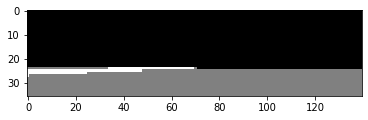

In [16]:
import matplotlib.pyplot as plt

def plot_action_space(agent):

    results = []
    xs = np.arange(-1.2, 0.6, 0.05)
    ys = np.arange(-0.07, 0.07, 0.001)

    for x in xs:
        tmp = []
        for y in ys:
            tmp.append(agent.get_action(np.array([x, y])))
        results.append(tmp)
    results = np.array(results)

    plt.imshow(results, cmap='gray', interpolation='none') 

plot_action_space(best_evolutionary_agent)

## Genetic algorithms

Dit zijn varianten van evolutionaire algoritmes waarbij gebruik gemaakt wordt van crossover van twee ouders

In [11]:
class GeneticAgent(Agent):
    num_parents = 2
    
    def __init__(self, num_inputs=1, num_outputs=1, hidden_layer_sizes=[]) -> None:
        super().__init__()

        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.hidden_layers_sizes = hidden_layer_sizes
        
        self._init_weights()
        
    def _init_weights(self):
        #print(self.hidden_layers_sizes)
        if len(self.hidden_layers_sizes) == 0:
            self.weights = [np.random.randn(self.num_inputs, self.outputs)]
        else:
            self.weights = []

            for index, hidden_layer in enumerate(self.hidden_layers_sizes):
                if index == 0:
                    self.weights.append(np.random.randn(self.num_inputs, hidden_layer))
                else:
                    self.weights.append(np.random.randn(self.hidden_layers_sizes[index-1], hidden_layer))
                
            self.weights.append(np.random.randn(hidden_layer, self.num_outputs))
                
    def copy(self):
        agent = GeneticAgent(self.num_inputs, self.num_outputs, self.hidden_layers_sizes)
        agent._init_weights()

        return agent
        

    def get_action(self, observation=None):

        action_prob = observation

        for index, hidden_layer in enumerate(self.weights):
            if index == len(self.weights)-1:
                # lineaire activatiefunctie
                action_prob = np.dot(action_prob, hidden_layer)
            else:
                # tanh activatiefunctie
                action_prob = np.tanh(np.dot(action_prob, hidden_layer))

        return np.argmax(action_prob)

    def mutate(self, parents=None, mutation_rate=None):
        if not isinstance(parents, list) and not isinstance(parents[0], GeneticAgent) and not isinstance(parents[1], GeneticAgent):
            return
        
        # Perform two-point crossover to create a child
        # totaal aantal gewichten
        total_size = 0
        for weight in self.weights:
            total_size += weight.shape[0] * weight.shape[1]

        # bepaal de cross-over points
        crossover_point1 = np.random.randint(0, total_size-2)
        crossover_point2 = np.random.randint(crossover_point1 + 1, total_size)
        
        # flatten weights
        weights_parent1 = np.concatenate([w.flatten() for w in parents[0].weights])
        weights_parent2 = np.concatenate([w.flatten() for w in parents[1].weights])

        # crossover weights
        # child 1 en 2 hebben de omgekeerde mutatie
        child_weights1 = np.concatenate((weights_parent1[:crossover_point1], weights_parent2[crossover_point1:crossover_point2], weights_parent1[crossover_point2:]), axis=0)
        child_weights2 = np.concatenate((weights_parent2[:crossover_point1], weights_parent1[crossover_point1:crossover_point2], weights_parent2[crossover_point2:]), axis=0)

        # recreate shapes
        stop_point = 0
        child1 = parents[0].copy()
        child2 = parents[1].copy()

        for index, layer in enumerate(self.hidden_layers_sizes):
            if index == 0:
                size = self.num_inputs * layer
            else:
                size = self.hidden_layers_sizes[index-1] * layer

            target_shape = parents[0].weights[0].shape
            child1.weights[index] = child_weights1[stop_point:stop_point+size].reshape(target_shape)
            child2.weights[index] = child_weights2[stop_point:stop_point+size].reshape(target_shape)

            stop_point += size
        
        return [child1, child2]
        

In [12]:
# Define the MountainCar environment
env = gym.make("MountainCar-v0")

# Hyperparameters
population_size = 100
mutation_rate = 0.4
num_generations = 100
num_episodes = 5

# RL agent with internally a NN with a hidden layer of 8 neurons
input_size = env.observation_space.shape[0]
output_size = env.action_space.n
agent = GeneticAgent(num_inputs=input_size, num_outputs=output_size, hidden_layer_sizes=[8])

best_genetic_agent = train_agent(env, agent, population_size=population_size, mutation_rate=mutation_rate, num_generations=num_generations, num_episodes=num_episodes)

Generation 1: Best Score = -136.6
Generation 2: Best Score = -145.2
Generation 3: Best Score = -148.2
Generation 4: Best Score = -145.2
Generation 5: Best Score = -146.6
Generation 6: Best Score = -149.6
Generation 7: Best Score = -135.6
Generation 8: Best Score = -152.4
Generation 9: Best Score = -166.8
Generation 10: Best Score = -154.4
Generation 11: Best Score = -165.6
Generation 12: Best Score = -135.0
Generation 13: Best Score = -164.8
Generation 14: Best Score = -165.8
Generation 15: Best Score = -161.4
Generation 16: Best Score = -131.4
Generation 17: Best Score = -131.4
Generation 18: Best Score = -114.8
Generation 19: Best Score = -131.2
Generation 20: Best Score = -115.2
Generation 21: Best Score = -123.6
Generation 22: Best Score = -139.6
Generation 23: Best Score = -115.2
Generation 24: Best Score = -114.8
Generation 25: Best Score = -115.6
Generation 26: Best Score = -115.4
Generation 27: Best Score = -122.2
Generation 28: Best Score = -139.6
Generation 29: Best Score = -

In [13]:
# Evaluate the best individual
env = gym.make("MountainCar-v0", render_mode="human")

for episode in range(5):
    score = simulate_env(env, best_genetic_agent)
    print(f"Best Individual Score: {score}")

Best Individual Score: -115.0
Best Individual Score: -122.0
Best Individual Score: -115.0
Best Individual Score: -145.0
Best Individual Score: -145.0


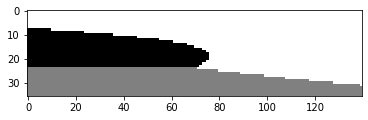

In [15]:
plot_action_space(best_genetic_agent)

## Met tensorflow

Een alternatieve manier om dit te doen is door gebruik te maken van een tensorflow model ipv de lagen van het neuraal netwerk zelf te berekenen.

Dit kan je doen als volgt:

In [17]:
import tensorflow as tf

class GeneticTFAgent(Agent):
    num_parents = 2
    
    def __init__(self, num_inputs=1, num_outputs=1, hidden_layer_sizes=[]) -> None:
        super().__init__()

        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.hidden_layers_sizes = hidden_layer_sizes
        
        self._init_weights()
        
    def _init_weights(self):

        self.model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.num_inputs,))
        ])
        for layer in self.hidden_layers_sizes:
            self.model.add(tf.keras.layers.Dense(layer, activation='relu'))

        self.model.add(tf.keras.layers.Dense(self.num_outputs, activation='linear'))
                
    def copy(self):
        agent = GeneticTFAgent(self.num_inputs, self.num_outputs, self.hidden_layers_sizes)
        agent._init_weights()

        return agent
        

    def get_action(self, observation=None):

        action_prob = self.model(observation[np.newaxis, :])
        return np.argmax(action_prob)

    def mutate(self, parents=None, mutation_rate=None):
        if not isinstance(parents, list) and not isinstance(parents[0], GeneticTFAgent) and not isinstance(parents[1], GeneticTFAgent):
            return
        
        child1 = parents[0].copy()
        child2 = parents[1].copy()
        
        # Get the weights of the parents and children
        parent1_weights = parents[0].model.get_weights()
        parent2_weights = parents[1].model.get_weights()

        parent1_weights_flattened = np.concatenate([weights.flatten() for weights in parent1_weights], axis=0)
        parent2_weights_flattened = np.concatenate([weights.flatten() for weights in parent2_weights], axis=0)

        # Perform two-point crossover on weights
        crossover_point1 = np.random.randint(0, len(parent1_weights_flattened)-1)
        crossover_point2 = np.random.randint(crossover_point1 + 1, len(parent1_weights_flattened))

        # crossover weights
        child_weights1 = np.concatenate((parent1_weights_flattened[:crossover_point1], parent2_weights_flattened[crossover_point1:crossover_point2], parent1_weights_flattened[crossover_point2:]), axis=0)
        child_weights2 = np.concatenate((parent2_weights_flattened[:crossover_point1], parent1_weights_flattened[crossover_point1:crossover_point2], parent2_weights_flattened[crossover_point2:]), axis=0)
        
        # mutation
        child_weights1 += mutation_rate * np.random.randn(*child_weights1.shape)
        child_weights2 += mutation_rate * np.random.randn(*child_weights2.shape)

        # recreate shapes
        child1_reshaped_weights = []
        child2_reshaped_weights = []
        idx = 0
        for layer in parent1_weights:
            size = layer.size
            child1_reshaped_weights.append(child_weights1[idx:idx+size].reshape(layer.shape))
            child2_reshaped_weights.append(child_weights2[idx:idx+size].reshape(layer.shape))
            idx += size

        # Set the weights back to the children
        child1.model.set_weights(child1_reshaped_weights)
        child2.model.set_weights(child2_reshaped_weights)
        
        return [child1, child2]
        

In [19]:
# Define the MountainCar environment
env = gym.make("MountainCar-v0")

# Hyperparameters
population_size = 100
mutation_rate = 0.4
num_generations = 100
num_episodes = 5

# RL agent with internally a NN with a hidden layer of 8 neurons
input_size = env.observation_space.shape[0]
output_size = env.action_space.n
agent = GeneticTFAgent(num_inputs=input_size, num_outputs=output_size, hidden_layer_sizes=[8])

best_genetictf_agent = train_agent(env, agent, population_size=population_size, mutation_rate=mutation_rate, num_generations=num_generations, num_episodes=num_episodes)

Generation 1: Best Score = -181.2
Generation 2: Best Score = -181.2
Generation 3: Best Score = -182.6
Generation 4: Best Score = -197.2
Generation 5: Best Score = -183.6
Generation 6: Best Score = -189.4
Generation 7: Best Score = -176.4
Generation 8: Best Score = -181.4
Generation 9: Best Score = -190.8
Generation 10: Best Score = -182.2
Generation 11: Best Score = -193.4


In [18]:
# Evaluate the best individual
env = gym.make("MountainCar-v0", render_mode="human")

for episode in range(5):
    score = simulate_env(env, best_genetictf_agent)
    print(f"Best Individual Score: {score}")

Best Individual Score: -115.0


KeyboardInterrupt: 

In [ ]:
plot_action_space(best_genetictf_agent)